In [282]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.simplefilter('ignore')

sns.set(rc = {'figure.figsize': (10, 10)})
%matplotlib inline

In [283]:
df = pd.read_csv('emaze_follows.csv')
df.head()

followId                            FollowerId  \
0        11  87E2923A-FD01-43AC-8369-864081916F83   
1        20  371088ec-ccd9-4c1e-acb3-6c3b43c84627   
2        21  24f13669-d3c4-431b-ae72-7c445aec412c   
3        22  a328005f-1ca5-4c79-961f-4eab118a32ab   
4        23  a328005f-1ca5-4c79-961f-4eab118a32ab   

                           InfluencerId  
0  8E665D3B-F5CD-48D2-8103-4B74B79A405F  
1  f7e6dd70-1b33-4d36-916b-c31e655555b5  
2  f7e6dd70-1b33-4d36-916b-c31e655555b5  
3  b0871e46-0322-4934-9b04-49dcf3ce3130  
4  bce93b7e-f594-4117-a354-1051f10fd56c

In [284]:
df.shape

(5377, 3)

In [285]:
#remove the 'following myself' cases
df = df[df['FollowerId']!=df['InfluencerId']]

In [286]:
df.shape

(4161, 3)

In [287]:
follower_id = df.FollowerId
influencer_id = df.InfluencerId
all_id = follower_id.append(influencer_id)
all_id = all_id.astype('category').cat.codes
follower_id_codes = all_id[:len(follower_id)]
influencer_id_codes = all_id[len(follower_id):]
df['FollowerCode'] = follower_id_codes
df['InfluencerCode'] = influencer_id_codes
df_updated = df.drop(columns = ['followId', 'FollowerId', 'InfluencerId'])

In [288]:
df_updated.head()

FollowerCode  InfluencerCode
0          1722            1755
1           727            3165
2           493            3165
3          2068            2229
4          2068            2400

In [289]:
#creating dictionary of followercodes/influencercodes to ids (for SVD)
follower_dict = dict(zip(df_updated['FollowerCode'], df['FollowerId']))
influencer_dict = dict(zip(df_updated['InfluencerCode'], df['InfluencerId']))

## Exploratory Analysis

#### Distribution of number of followers

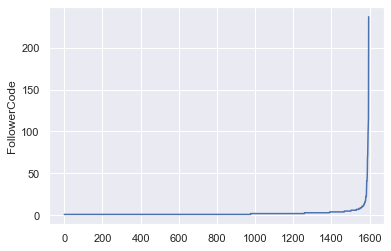

In [290]:
a = df_updated.groupby('InfluencerCode')[['FollowerCode']].count().sort_values(by = 'FollowerCode').reset_index()
sns.lineplot(x =a.index, y ='FollowerCode', data = a)

#### Distribution of number following

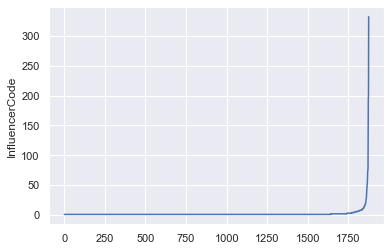

In [291]:
a = df_updated.groupby('FollowerCode')[['InfluencerCode']].count().sort_values(by = 'InfluencerCode').reset_index()
sns.lineplot(x =a.index, y ='InfluencerCode', data = a)

# Building Graph

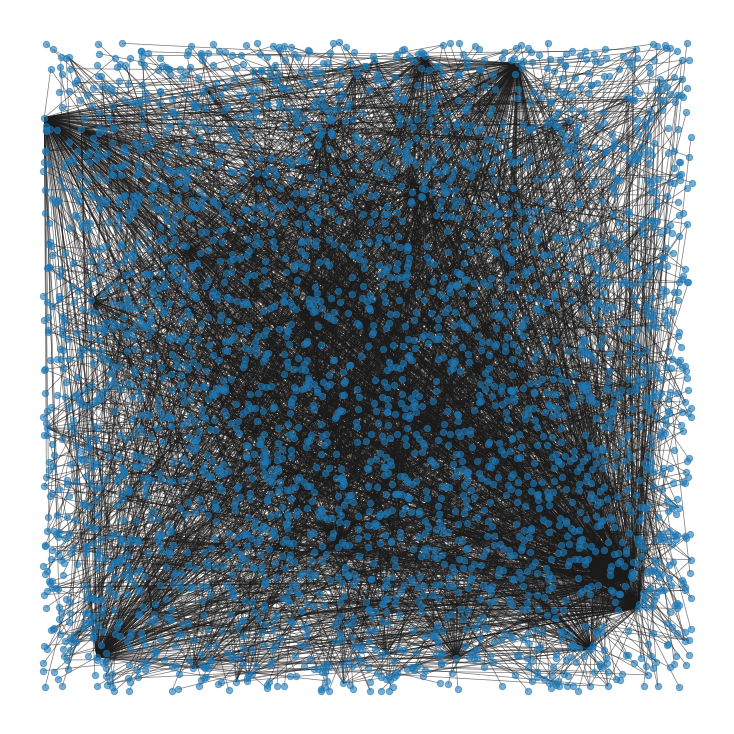

In [292]:
G = nx.from_pandas_edgelist(df = df_updated, source = 'FollowerCode', target = 'InfluencerCode', 
                            create_using = nx.Graph())
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

# Generating Training Data

Here, we calculate missing edges by considering nodes that are far apart, reducing their likelihood of being connected in the future.

We later use downsampling to take a subset of these missing edges to account for an extreme imbalance in the data

This is a temporary solution to the problem of not having a proper training set.

Another problem here is that a majority of disconnected nodes or those with no edge between them are those
that have no path between them i.e. the shortest walk is -1 which creates bias in the data and is something
that will only be solved as the social network grows

In [293]:
follower_list = df_updated.FollowerCode.unique().tolist()
influencer_list = df_updated.InfluencerCode.unique().tolist()

df_train_pos = pd.DataFrame(columns = ['node1', 'node2', 'link'])
df_train_pos['link'] = 1
df_train_pos['node1'] = df_updated.FollowerCode
df_train_pos['node2'] = df_updated.InfluencerCode

#generating negative samples

#we take these separate to account for imbalance in data and the social network being relatively disconnected
missing_edge = []

for i in tqdm(follower_list):
    for j in influencer_list:
        if i != j:
            try:
                #this is an assumption, we need to determine a quality metric for this one
                #perhaps if far apart + the j is not an influencer
                if nx.shortest_path_length(G, i, j) > 5:
                    missing_edge.append([i, j])

            except nx.NetworkXNoPath:
                missing_edge.append([i, j])
                #this can be handled in multiple ways

            


100%|██████████| 1876/1876 [01:22<00:00, 22.83it/s]

In [294]:
len(missing_edge)

1892219

In [295]:
from sklearn.utils import resample
df_train_neg = pd.DataFrame(missing_edge)

df_train_neg = resample(df_train_neg, 
                        replace=False,    # no replacement
                        n_samples=4000,     # close to the minority class
                        random_state=42)

df_train_neg['link'] = 0
df_train_neg.columns = ['node1', 'node2', 'link']
df_train_neg.head()

node1  node2  link
485793     345   3177     0
1116183   2116    647     0
684201     306   1949     0
1582712   2430   1253     0
693885     748   1327     0

In [296]:
df_train_neg.shape

(4000, 3)

In [297]:
df_train_pos['link'] = 1
df_train = pd.concat([df_train_pos, df_train_neg])


# Feature Engineering

#### Functions to compute Metrics

In [298]:
def jaccard(node1, node2, Graph = G):
    pred = nx.jaccard_coefficient(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p
    
def adamic_adar(node1, node2, Graph = G):
    pred = nx.adamic_adar_index(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p
    
def resource_allocation_index(node1, node2, Graph = G):
    pred = nx.resource_allocation_index(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p

def cosine_similarity(node1, node2, Graph = G):
    neighbor1 = set(G.neighbors(node1))
    neighbor2 = set(G.neighbors(node2))
    
    return (len(neighbor1.intersection(neighbor2))/(np.sqrt(len(neighbor1)*len(neighbor2))))

def preferential_attachment(node1, node2, Graph = G):
    pred = nx.preferential_attachment(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p
    
def sorensen_index(node1, node2, Graph = G):
    sum_deg = G.degree(node1)+G.degree(node2)
    neighbor1 = set(G.neighbors(node1))
    neighbor2 = set(G.neighbors(node2))
    try:
        return (2*len(neighbor1.intersection(neighbor2)))/(sum_deg)
    except:
        return -1

def lhni(node1, node2, Graph = G):
    prod_deg = G.degree(node1)*G.degree(node2)
    neighbor1 = set(G.neighbors(node1))
    neighbor2 = set(G.neighbors(node2))
    try:
        
        return (len(neighbor1.intersection(neighbor2)))/(prod_deg)
    except:
        return -1

#tes
def shortest_walk(node1, node2, Graph = G):
    sw = 0
    try:
        if G.has_edge(node1, node2):
            G.remove_edge(node1, node2)
            sw = nx.shortest_path_length(G, node1, node2)
            G.add_edge(node1, node2)
        else:
            sw = nx.shortest_path_length(G, node1, node2)
        
        return sw
    except nx.NetworkXNoPath:
        return -1 #we can change this and put something else

def hopcroft(node1, node2, Graph = G):
    pred = nx.ra_index_soundarajan_hopcroft(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p

#we can add more and others as we see fit...

In [299]:
def add_engineered_features(df):
    df_train = df.copy()
    df_train['jaccard'] = df_train.apply(lambda row: jaccard(row['node1'], row['node2']), axis = 1)
    df_train['adamic_adar'] = df_train.apply(lambda row: adamic_adar(row['node1'], row['node2']), axis = 1)
    df_train['resource_allocation_index'] = df_train.apply(lambda row: resource_allocation_index(row['node1'], row['node2']), axis = 1)
    df_train['cosine_similarity'] = df_train.apply(lambda row: cosine_similarity(row['node1'], row['node2']), axis = 1)
    df_train['preferential_attachment'] = df_train.apply(lambda row: preferential_attachment(row['node1'], row['node2']), axis = 1)
    df_train['sorensen'] = df_train.apply(lambda row: sorensen_index(row['node1'], row['node2']), axis = 1)
    df_train['lhni'] = df_train.apply(lambda row: lhni(row['node1'], row['node2']), axis = 1)
    df_train['shortest_walk'] = df_train.apply(lambda row: shortest_walk(row['node1'], row['node2']), axis = 1)
    return df_train

In [300]:
#Add engineered features to data

# df_train['jaccard'] = df_train.drop(columns = ['link']).apply(lambda row: jaccard(row['node1'], row['node2']), axis = 1)
# df_train['adamic_adar'] = df_train.drop(columns = ['link']).apply(lambda row: adamic_adar(row['node1'], row['node2']), axis = 1)
# df_train['resource_allocation_index'] = df_train.drop(columns = ['link']).apply(lambda row: resource_allocation_index(row['node1'], row['node2']), axis = 1)
# df_train['cosine_similarity'] = df_train.drop(columns = ['link']).apply(lambda row: cosine_similarity(row['node1'], row['node2']), axis = 1)
# df_train['preferential_attachment'] = df_train.drop(columns = ['link']).apply(lambda row: preferential_attachment(row['node1'], row['node2']), axis = 1)
# df_train['sorensen'] = df_train.drop(columns = ['link']).apply(lambda row: sorensen_index(row['node1'], row['node2']), axis = 1)
# df_train['lhni'] = df_train.drop(columns = ['link']).apply(lambda row: lhni(row['node1'], row['node2']), axis = 1)
# df_train['shortest_walk'] = df_train.drop(columns = ['link']).apply(lambda row: shortest_walk(row['node1'], row['node2']), axis = 1)
# #df_train['hopcroft'] = df_train.drop(columns = ['link']).apply(lambda row: hopcroft(row['node1'], row['node2']), axis = 1)
df_train_transformed = add_engineered_features(df_train.drop(columns = ['link']))
df_train_transformed['link'] = df_train.link.values

In [301]:
df_train_transformed[df_train_transformed.link==1].head()

node1  node2   jaccard  adamic_adar  resource_allocation_index  \
0   1722   1755  0.000000     0.000000                   0.000000   
1    727   3165  0.000000     0.000000                   0.000000   
2    493   3165  0.000000     0.000000                   0.000000   
3   2068   2229  0.029046     1.974852                   0.231129   
4   2068   2400  0.066667     5.649903                   0.821769   

   cosine_similarity  preferential_attachment  sorensen      lhni  \
0           0.000000                        1  0.000000  0.000000   
1           0.000000                      146  0.000000  0.000000   
2           0.000000                        4  0.000000  0.000000   
3           0.074557                     8815  0.056452  0.000794   
4           0.133370                    20295  0.125000  0.000936   

   shortest_walk  link  
0             -1     1  
1              3     1  
2              3     1  
3              2     1  
4              2     1

In [302]:
#this is a problem
df_train_transformed[(df_train_transformed.link==0)&(df_train_transformed.shortest_walk==-1)].head()

node1  node2  jaccard  adamic_adar  resource_allocation_index  \
485793     345   3177      0.0          0.0                        0.0   
1116183   2116    647      0.0          0.0                        0.0   
684201     306   1949      0.0          0.0                        0.0   
1582712   2430   1253      0.0          0.0                        0.0   
693885     748   1327      0.0          0.0                        0.0   

         cosine_similarity  preferential_attachment  sorensen  lhni  \
485793                 0.0                        3       0.0   0.0   
1116183                0.0                        1       0.0   0.0   
684201                 0.0                        1       0.0   0.0   
1582712                0.0                        1       0.0   0.0   
693885                 0.0                        1       0.0   0.0   

         shortest_walk  link  
485793              -1     0  
1116183             -1     0  
684201              -1     0  
1582712             -1     0  
693885              -1     0

Note how a majority of shortest walks in the above table are negative one. This is because of the social network currently not being developed coupled with the strategy used to generate training data. While tweaks can be made to temporarily mask the problem, its solution is truly building the social network. Building the social network would further allow more effective metrics since with the current state, it is more likely to notice anomalies i.e. edges between nodes that have no common friends or any similarity...

In [303]:
from sklearn.preprocessing import StandardScaler
df_train_transformed['cosine_similarity'] = df_train_transformed['cosine_similarity'].fillna(0)

In [304]:
df_important = df_train_transformed[['node1','node2','link']]

In [305]:
numerical_cols = df_train_transformed.drop(columns=['node1', 'node2', 'link'],axis=1).columns

In [306]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
numerical_data_imputed_normalized = pd.DataFrame(
    #We're created a new dataframe where our columns have been imputed and normalized
    normalize(SimpleImputer(strategy="median").fit_transform(df_train_transformed[numerical_cols])),
    columns=numerical_cols
)
numerical_data_imputed_normalized.head()

jaccard  adamic_adar  resource_allocation_index  cosine_similarity  \
0  0.000000     0.000000                   0.000000           0.000000   
1  0.000000     0.000000                   0.000000           0.000000   
2  0.000000     0.000000                   0.000000           0.000000   
3  0.000003     0.000224                   0.000026           0.000008   
4  0.000003     0.000278                   0.000040           0.000007   

   preferential_attachment  sorensen          lhni  shortest_walk  
0                 0.707107  0.000000  0.000000e+00      -0.707107  
1                 0.999789  0.000000  0.000000e+00       0.020544  
2                 0.800000  0.000000  0.000000e+00       0.600000  
3                 1.000000  0.000006  9.008519e-08       0.000227  
4                 1.000000  0.000006  4.612915e-08       0.000099

In [331]:
x_train = numerical_data_imputed_normalized.values
y_train = df_train_transformed.link.values

# Creating the Model

### Logistic Regression

In [332]:
lr = LogisticRegression()
lr.fit(x_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [333]:
from sklearn import metrics

In [334]:
pred = lr.predict(x_train)

In [335]:
#get the prediction probabilities (prob of 0 and prob of 1)
predict_prob = lr.predict_proba(x_train)

In [336]:
#turn prediction probs into a df to be combined with df_train
probs_df = pd.DataFrame(predict_prob)

In [337]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_train, pred)

array([[3392,  608],
       [ 779, 3382]])

In [338]:
from sklearn.model_selection import cross_val_score

def evaluate_model(classifier):
    eval_dict = {}
    eval_dict['accuracy'] = cross_val_score(
        classifier, x_train, y_train, scoring="accuracy", cv=5
    ).mean()
    eval_dict['recall'] = cross_val_score(
        classifier, x_train, y_train, scoring="recall", cv=5
    ).mean()
    eval_dict['precision'] = cross_val_score(
        classifier, x_train, y_train, scoring="precision", cv=5
    ).mean()
    eval_dict['f1'] = cross_val_score(
        classifier, x_train, y_train, scoring="f1", cv=5
    ).mean()
    return eval_dict

In [339]:
cv_scores = evaluate_model(lr)
pd.DataFrame.from_dict(cv_scores.items())

0         1
0   accuracy  0.830044
1     recall  0.812780
2  precision  0.847072
3         f1  0.827917

In [340]:
from sklearn.tree import DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier()
# tree_classifier.fit(x_train, y_train)
# pred = classifier.predict(x_train)

In [341]:
cv_score = evaluate_model(tree_classifier)
pd.DataFrame.from_dict(cv_score.items())

0         1
0   accuracy  0.833353
1     recall  0.717132
2  precision  0.943299
3         f1  0.809630

In [342]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
cv_score = evaluate_model(rfc)
pd.DataFrame.from_dict(cv_score.items())

0         1
0   accuracy  0.834578
1     recall  0.723142
2  precision  0.939220
3         f1  0.814147

Logistic regression beats out the other two on recall while RandomForest and Decision trees perform better on precision. We take that false negatives cost us more i.e. potential links incorrectly identified as non-links are more costly than the other way around and thus, we choose logistic regression for the time being. In the future, we can experiment with gradient boosting although that may be resource intensive

# Recommendations

In [319]:
rec_edge = []
for i in tqdm(follower_list):
    for j in influencer_list:
        if i != j:
            try:
                if not(G.has_edge(i, j)) and nx.has_path(G, i, j):
                    rec_edge.append([i, j])

            except nx.NetworkXNoPath:
                pass
                #this error will never happen given the above condition
#                 missing_edge.append([i, j])
                #this can be handled in multiple ways



100%|██████████| 1876/1876 [00:22<00:00, 83.44it/s]

In [320]:
# df_rec = pd.DataFrame.sample(pd.DataFrame(rec_edge), n = 50000)
# df_rec.head()
df_rec = pd.DataFrame(rec_edge)
df_rec.head()

0     1
0  727  2766
1  727  2614
2  727   799
3  727   641
4  727  2091

In [321]:
df_rec.shape

(137180, 2)

In [322]:
# df_rec = pd.DataFrame(rec_edge)
df_rec.columns = ['node1', 'node2']
df_rec_updated = add_engineered_features(df_rec)
df_rec_updated.head()

node1  node2   jaccard  adamic_adar  resource_allocation_index  \
0    727   2766  0.016393     0.192160                   0.005495   
1    727   2614  0.016393     0.192160                   0.005495   
2    727    799  0.033333     0.424498                   0.019008   
3    727    641  0.033333     0.424498                   0.019008   
4    727   2091  0.050000     0.636430                   0.027937   

   cosine_similarity  preferential_attachment  sorensen      lhni  \
0           0.091287                      120  0.032258  0.008333   
1           0.091287                      120  0.032258  0.008333   
2           0.182574                      120  0.064516  0.016667   
3           0.182574                      120  0.064516  0.016667   
4           0.223607                      180  0.095238  0.016667   

   shortest_walk  
0              2  
1              2  
2              2  
3              2  
4              2

In [328]:
df_rec_updated['cosine_similarity'] = df_rec_updated['cosine_similarity'].fillna(0)

In [329]:
df_rec_updated.head()

node1  node2   jaccard  adamic_adar  resource_allocation_index  \
0    727   2766  0.016393     0.192160                   0.005495   
1    727   2614  0.016393     0.192160                   0.005495   
2    727    799  0.033333     0.424498                   0.019008   
3    727    641  0.033333     0.424498                   0.019008   
4    727   2091  0.050000     0.636430                   0.027937   

   cosine_similarity  preferential_attachment  sorensen      lhni  \
0           0.091287                      120  0.032258  0.008333   
1           0.091287                      120  0.032258  0.008333   
2           0.182574                      120  0.064516  0.016667   
3           0.182574                      120  0.064516  0.016667   
4           0.223607                      180  0.095238  0.016667   

   shortest_walk  
0              2  
1              2  
2              2  
3              2  
4              2

In [343]:
df_imp = df_rec_updated[['node1', 'node2']]
df_rec_updated = df_rec_updated.drop(columns = ['node1', 'node2'])

In [344]:
df_rec_transformed = pd.DataFrame(
    #We're created a new dataframe where our columns have been imputed and normalized
    normalize(SimpleImputer(strategy="median").fit_transform(df_rec_updated))
)

In [345]:
df_imp['link'] = lr.predict(df_rec_transformed.values)

In [346]:

dif = pd.DataFrame(lr.predict_proba(df_rec_transformed.values))[1]
df_imp['link_prob'] = dif


In [347]:
df_imp.sort_values(by = ['link_prob'], ascending = False).head()

node1  node2  link  link_prob
13328   1661   2758     1   0.999998
13349   1661   2291     1   0.999998
78468   3266   2291     1   0.999998
13410   1661     63     1   0.999998
13330   1661   2646     1   0.999998

In [348]:
df_imp['link'].value_counts()

1    137180
Name: link, dtype: int64

In [349]:
df_svd = df_imp.drop(columns = ['link'])
df_svd.head()


node1  node2  link_prob
0    727   2766   0.902225
1    727   2614   0.902225
2    727    799   0.902269
3    727    641   0.902269
4    727   2091   0.897776

# Recommendation without SVD

In [384]:
follow_matrix_df = df_svd.pivot_table(
    values='link_prob',
    index='node1',
    columns='node2'
)

In [385]:
follower_id_list = np.array(follow_matrix_df.index.tolist())
influencer_id_list = np.array(follow_matrix_df.columns.tolist())

In [386]:
follow_matrix_df = follow_matrix_df.fillna(0)

def recommend(follower_list, num_results=5):
    for follower in follower_list:
        # get the row index of follower
        follower_indx = np.where(follower_id_list == follower)[0][0]
                
        # sort all vales for follower row in descending order
        indx_sort = follow_svd[follower_indx, :].argsort()[::-1]

        rec_ids = influencer_id_list[indx_sort]
        rec_name = [influencer_dict[x] for x in rec_ids]

        rows.append([follower_dict[follower],rec_name[:num_results]])

In [387]:
recommend(follower_id_list)

In [388]:
reco_df_nosvd = pd.DataFrame(rows, columns=col)

In [389]:
reco_df_nosvd.head()

follower  \
0  001ada80-f7ef-4618-b15e-c77e6c6a0d1f   
1  0023eb93-b95b-4c84-9e3a-93a9400fae09   
2  004819a4-25d8-4cac-82df-c381c632d58d   
3  00e0c740-4c50-4d43-80d5-87ff32cc2989   
4  017da4bc-15c6-476c-80b1-689abe7b2783   

                                      influencer_rec  
0  [b0871e46-0322-4934-9b04-49dcf3ce3130, dbbcd8b...  
1  [00e0c740-4c50-4d43-80d5-87ff32cc2989, efdfb0d...  
2  [95ae231b-eb97-4633-a51e-8474aac2b64d, fe9ed30...  
3  [3efa4e82-0b8c-4556-b353-1f7a34f443d8, 723ccc8...  
4  [5a8dfd04-18f1-41aa-9a1b-d388bd42a269, c4d6620...

In [390]:
reco_df_nosvd.influencer_rec[0]

['b0871e46-0322-4934-9b04-49dcf3ce3130',
 'dbbcd8bf-2279-49b4-be21-f1b823d100a7',
 '184e25e9-652b-48a4-81f7-0fca284f14c0']

# Recommendation with SVD

In [391]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

In [392]:
#creating sparse matrix
follow_mtx = follow_matrix_df.fillna(0).values.copy()
follow_sparse_mtx = coo_matrix(follow_mtx)

In [393]:
follow_sparse_mtx

<273x512 sparse matrix of type '<class 'numpy.float64'>'
	with 137180 stored elements in COOrdinate format>

## SVD of Matrix

In [394]:
U, s, V = svds(follow_sparse_mtx, k=10)

## Multiply the decomposition back to get approx matrix

In [395]:
s_diag = np.diag(s)

In [396]:
follow_svd = U @ s_diag @ V

In [397]:
follow_svd

array([[0.64742933, 0.96866898, 0.75149774, ..., 0.97009606, 0.89926395,
        0.95894627],
       [0.96374399, 0.99531473, 0.96423246, ..., 0.99592955, 0.9695995 ,
        1.00057898],
       [0.97746215, 0.99874071, 0.98987582, ..., 0.99500937, 1.02181373,
        1.00841083],
       ...,
       [1.2032339 , 0.76940777, 0.97909921, ..., 0.81457477, 0.95046032,
        0.29946921],
       [0.98502004, 0.98442871, 1.0051275 , ..., 0.97972346, 1.02535128,
        0.99339991],
       [0.9339304 , 0.99630146, 0.99634328, ..., 0.99876279, 0.99190481,
        0.97460019]])

## Recommend function

In [398]:
col = ["follower","influencer_rec"]
rows = []
def recommend(follower_list, num_results=3):
    for follower in follower_list:
        
        # get the row index of follower
        follower_indx = np.where(follower_id_list == follower)[0][0]
        
        # sort all vales for follower row in descending order
        indx_sort = follow_svd[follower_indx, :].argsort()[::-1]
        
#         # create mask and get the index of only influencers never followed
#         never_follow = follow_mtx[follower_indx, :][indx_sort] == 0
    
        rec_ids = influencer_id_list[indx_sort]
        rec_name = [influencer_dict[x] for x in rec_ids]
        
        rows.append([follower_dict[follower],rec_name[:num_results]])

In [399]:
#calling the recommend function on the entire list of follower Ids
recommend(follower_id_list)

In [400]:
#turning the rows and cols into a df
reco_df_withsvd = pd.DataFrame(rows, columns=col)

In [401]:
reco_df_withsvd.influencer_rec[0]

['b0871e46-0322-4934-9b04-49dcf3ce3130',
 'dbbcd8bf-2279-49b4-be21-f1b823d100a7',
 '184e25e9-652b-48a4-81f7-0fca284f14c0']

## Export to csv

In [62]:
#reco_df_<technique>.to_csv('recommend_users.csv')